In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import bets
import os
import glob
import datetime as dt
import time
#import ot
import json
import requests
import statsmodels.api as sm 
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)
nba = bets.nba()
import seaborn as sns
import matplotlib.pyplot as plt
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from nba_api.stats.endpoints import leaguegamefinder,BoxScoreSummaryV2,LeagueDashOppPtShot,PlayerProfileV2,GameRotation

In [ ]:
temp = GameRotation('0021700003').get_data_frames()

In [ ]:
game_ids = pd.read_sql('select game_id from teamLog',nba.conn).values.flatten()

In [ ]:
temp[0][temp[0].IN_TIME_REAL==0].PERSON_ID.values

In [ ]:
test = pd.concat(temp)

In [ ]:
len(game_ids)

In [ ]:
d = {}
missing = []
for idx,gid in enumerate(tqdm(game_ids)):
    try:
       
    except:
        missing.append(gid)
    if idx % 200 == 0:
        time.sleep(np.random.choice(range(25,45)))
    

In [ ]:
len(missing)

In [ ]:
nba.conn.execute('ALTER TABLE plyrLogs ADD COLUMN Starter int;')
nba.conn.commit()

In [537]:
def reload_table(table,filepath=None,data=None):
   
    try:
        nba.conn.execute('DROP TABLE {}'.format(table))
        nba.conn.commit()
    except:
        print('No table to delete, creating {}'.format(table))
    if filepath != None:
        file = open(filepath,'r').read()
        try:
            nba.conn.execute(file)
        except:
            '{} table already exists'.format(table)
    nba.insert_data(data,table)

#### EDA

What do we want to know:
- Team info
    1. home court advantage?
    2. what is the proportion of games that win by 6+/11+/15+/26+/31+
    3. quarter win distributions
    4. rest, will need rest since last game, number of games in 3/4/5 nights
    

In [ ]:
## What do games spreads look like 6/11/26 point victories - landmarks in espn

In [ ]:
tm = pd.read_sql('select * from team_game',nba.conn)

In [ ]:
tm['ptDiff'] = tm.game_points_scored - tm.points_allowed

In [ ]:
tm[tm.ptDiff >= 1].ptDiff.describe([x/100 for x in range(10,110,10)])

In [ ]:
for season in tm.season.unique():
    print(season)
    df = tm[(tm.ptDiff>0) & (tm.season==season)]
    print(df.ptDiff.describe([x/100 for x in range(10,110,10)]))
    sns.ecdfplot(df.ptDiff)
    plt.vlines(x=df.ptDiff.mean(),ymin=0,ymax=1,colors='red')
    plt.show()

In [ ]:
#what does 
def pyth_win_exp(pf,pa):
    return np.round(pf ** 16.5 / (pf ** 16.5 + pa ** 16.5),3)

In [ ]:
f20 = tm[tm.game_number < 20]
f20wins = f20.groupby(['season','team']).win.value_counts(normalize=True).reset_index(name='wperc')
f20wins = f20wins[f20wins.win==1].drop('win',axis=1)

In [ ]:
pyth = pyth_win_exp(f20.groupby(['season','team']).game_points_scored.sum(), f20.groupby(['season','team']).points_allowed.sum()).reset_index(name='pythPerc')

In [ ]:
f20wins = f20wins.merge(pyth,how='inner',on=['season','team'])

In [ ]:
f20wins

In [ ]:
wPerDf = (tm.groupby(['season','team']).win.sum() / tm.groupby(['season','team']).game_id.nunique()).reset_index(name='actualWPerc')

In [ ]:
df = f20wins.merge(wPerDf,how='left',on=['season','team'])

In [ ]:
df.actualWPerc

In [ ]:
(df.pythPerc - df.actualWPerc).describe([x/100 for x in range(10,110,10)]) * 100

In [ ]:
(df.wperc - df.actualWPerc).describe([x/100 for x in range(10,110,10)]) * 100

In [ ]:
ols = sm.regression.linear_model.OLS
linear_model = ols(endog=df.actualWPerc,exog = df.pythPerc).fit() 
linear_model.summary()

In [ ]:
# looking at these it seems that 20 games 

In [ ]:
f20['ptDiff'] = f20.game_points_scored - f20.points_allowed

In [ ]:
lg = tm[tm.game_number >= 20]

In [ ]:
lgw = lg.groupby(['season','team']).win.value_counts(normalize=True).reset_index(name='lgWinperc')
lgw = lgw[lgw.win==1].drop('win',axis=1)

In [ ]:
df = df.merge(lgw,how='left',on=['season','team'])

In [ ]:
df

In [ ]:
linear_model = ols(endog = df.lgWinperc, exog= df.wperc, 
                   ).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'wperc',
                             fig=fig)

In [ ]:
linear_model.summary()

In [ ]:
linear_model = ols(endog = df.lgWinperc,exog = df.pythPerc, 
                  ).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'pythPerc',
                             fig=fig)

In [ ]:
linear_model.summary()

In [ ]:
sortedVals = ['10','11','12','01','02','03','04','05']

In [ ]:

data = tm[tm.win==1].groupby(['season','MONTH']).ptDiff.mean().reset_index()
plt.figure(figsize = (16,8))
sns.barplot(data,x = 'season', y = 'ptDiff',hue='MONTH',hue_order=sortedVals)
plt.show()

 It does seem to increase through the year as april tends to be a high month for spreads.
 2024 there is sentiment that there was a change in refereeing

In [ ]:
plt.figure(figsize = (14,8))
sns.ecdfplot(tm[(tm.win==1)].ptDiff)
plt.show()

In [ ]:
tm[(tm.home==1)].win.value_counts(normalize=True)

In [ ]:
tm[(tm.home==1)].groupby('season').win.sum() / tm.groupby('season').game_id.nunique()

In [ ]:
#back-to-backs
print(tm[(tm.daysBetweenGames==0)].win.value_counts(normalize=True))
tm[(tm.daysBetweenGames==0)].groupby('season').win.sum() / tm[(tm.daysBetweenGames==0)].groupby('season').game_id.nunique()

In [530]:
def update_view(viewName,file):
    try:
        nba.conn.execute('DROP VIEW {}'.format(viewName))
        nba.conn.commit()
    except:
        '{} does not exist'.format(viewName)
    nba.conn.execute(open(file,'r').read())
    nba.conn.commit()
    print('{} View has been updated'.format(viewName))

In [ ]:
nba.showTables

### Want to look through player information will want to build out a clustering for player types


In [532]:
update_view('pgames','data/sql/playerGameView.sql')

pgames View has been updated


In [ ]:
plog = pd.read_sql('select * from pgames',nba.conn).fillna(0)

In [ ]:
## There are 350 undrafted players, Fred van leet is the only all-star, I dont think missing exp will matter too much for them
test = pd.read_sql('''select * from players where pick = 'Undrafted' ''',nba.conn)

In [ ]:
#lets see how offensive/defensive and net rating look for the top 50 players
#need to get a yearly offensive rating

In [ ]:
def true_shooting(plog,game=True):
    if game:
        ts = plog.pts / (2*plog.filter([col for col in plog.columns if re.search('_fga$',col)!=None]).sum(axis=1) + .44 * plog.fta)
        plog['ts'] = ts
        return plog
    else: 
        df = plog.groupby(['player_id','name','season'])[['pts','fta']+shots].sum().reset_index()
        df['ts'] = df.pts / (2*df.filter([col for col in df.columns if re.search('_fga$',col)!=None]).sum(axis=1) + .44 * df.fta)
        return df[['player_id','name','season','ts']]

In [ ]:
tsSeas = true_shooting(plog,game=False)


In [ ]:
sns.histplot(plog.offensiveRating)
plt.show()

In [ ]:
plog = plog.replace(np.inf,np.nan)

In [ ]:
sns.scatterplot(data = plog,y='offensiveRating',x='usagePercentage')
plt.xlim(.1,1.2)
plt.show()

In [ ]:
sns.histplot(plog.ts)
plt.xlim(.1,1.2)
plt.show()

In [ ]:
def shot_profile(plog):
    temp = plog.filter(['player_id','season','name','blka','usagePercentage'] +[col for col in plog.columns if re.search('_fg|^ft',col)!=None])
    plyrDemo = pd.read_sql('select * from players',nba.conn)
    grp = temp.groupby(['season','player_id','name']).median().reset_index()
    
    return grp

In [ ]:
shdf = shot_profile(plog)

In [ ]:
plyrDemo = pd.read_sql('''select * from players
                        ''',nba.conn)

In [ ]:
seasons = pd.read_sql('select distinct season from teamLog',nba.conn).values.flatten()

In [ ]:
def award_counts(df):
    '''Gets a count of the number of instances a player has achieve some honor relative to that season, this is done player by player
    for each award
    Inputs: DataFrame: must have season column and at least one of the following: 
    allstars, all-nba[1-2-3], mvp, mip, dpoy, all-d[1,2], finals mvp.  Ideally DataFrame is at season level.
    Output: df with new column(s)'''
    awardCols = ['allstars','allnba_first','allnba_second','allnba_third','alld_first','alld_second','mip','dpoy','mvp','finals_mvp']
    for col in awardCols:
        df[col+'_count'] = [len([x for x in b.split(',') if x <a]) for a, b in zip(test['season'], test[col].fillna('None'))]
        df = df.drop(awardCols,axis=1)
    return df

In [ ]:
rateTemp = temp[['season']]
# locations = list(set([col[:col.find('_')] for col in temp.columns if col.find('_fg')>-1]))
# for col in locations:
#     rateTemp[col+'_rate'] = temp[col+'_fgm'] / temp[col+'_fga']
# rateTemp

In [ ]:
plog[plog.season=='2023-24'].groupby(['player_id','name'])[['paint_fgm','paint_fga']].sum().sort_values(by='paint_fgm',ascending=False)

In [ ]:
for col in locations:
    print(col)
    print(plog[col+'_fga'].describe(np.arange(.1,1,.1)))

In [ ]:
check = nba.update_player_log(['2024-03-07'])

In [ ]:
temp[col].max()

In [ ]:
plog['thr_fga'] = plog.rc_fga + plog.lc_fga + plog.abv_fga
temp = plog.groupby(['season','player_id','name'])[[x for x in plog.columns if x.find('_fg')>-1]].median().reset_index()
for col in temp.columns:
    if temp[col].dtypes!='O':
        plt.title(col)
        sns.histplot(temp[col],binwidth=1)
        plt.vlines(x = temp[col].mean(),ymin=0,ymax=temp[col].max(),color='red')
        plt.show()

In [ ]:
from nba_api.stats.endpoints import BoxScorePlayerTrackV2,BoxScorePlayerTrackV3,synergyplaytypes

In [ ]:
seasons = pd.read_sql('select distinct season from teamLog',nba.conn).values.flatten()
def get_synergy_data(seasons):
    '''
    Inputs: a list of seasons
    Output: dataframe of synergy pick n roll ballhandler data and isolation data.
    '''
    synCols = ['PLAYER_ID','TEAM_ID','POSS_PCT','PPP','TOV_POSS_PCT','POSS']
    final = pd.DataFrame()
    ptypes = {'Isolation':'Iso','PRBallHandler':'pnr','Spotup':'spot'}
    for ptype in list(ptypes.keys()):
        print('starting {}'.format(ptype))

        for season in tqdm(seasons):
            df = synergyplaytypes.SynergyPlayTypes(per_mode_simple='PerGame',season = season
                                       ,player_or_team_abbreviation='P',play_type_nullable=ptype,type_grouping_nullable='offensive').get_data_frames()[0]
            df = df.filter(synCols)
            df.columns = ['{}_{}'.format(col,ptypes[ptype]) if re.search('ID$',col)==None else col for col in df.columns]
            df['season'] = season
            final = pd.concat([final,df])
    final = final.groupby(['PLAYER_ID','TEAM_ID','season']).sum().reset_index()
    return final

In [ ]:
syn = get_synergy_data(seasons)

## Clustering

In [ ]:
def true_shooting(plog):
    ts = plog.pts / (2*plog.filter([col for col in plog.columns if re.search('_fga$',col)!=None]).sum(axis=1) + .44 * plog.fta)
    plog['ts'] = ts
    return plog

def award_counts(demo,cols=None):
    '''
    Inputs: DF at season level, will be using season and the columns to count awards, will default to all awards
    Output: new dataframe with count columns replacings the columns for each instance
    '''
    awards = ['allstars', 'allnba_first','allnba_second', 'allnba_third', 'alld_first', 'alld_second', 'mip',
       'dpoy', 'mvp', 'finals_mvp']
    demo = demo.fillna('N/A')
    if cols == None:
        cols = awards
    lasts = ['allstars', ['allnba_first','allnba_second', 'allnba_third'],['alld_first', 'alld_second'],'mvp','dpoy']
    #This is checking to find the last time they were all-star, all-nba, all-d, mvp or dpoy, goes first to use years
    for lst in lasts:
        if isinstance(lst,str):
            demo['last_'+lst] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in zip(demo.season,demo[lst])]
        else:
            name = lst[0][:lst[0].find('_')]
            grp = zip(demo.season,[','.join(x) for x in demo.filter(lst).values])
            demo['last_'+name] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in grp]
    #This goes through every award and will update the column with a count instead of the string of instances
    for col in cols:
        demo[col] = [len([a for a in awrd.split(',') if a < season]) for season,awrd in zip(demo.season,demo[col])]
    
    return demo


def player_off_data(breakouts=True):
    #Set variables and get data

    ind = ['player_id','name','season']
    mmm = ['min','median','max']
    dec = np.arange(.1,1,.1)
    quarts = np.arange(.25,1,.25)
    quints = np.arange(.2,1,.2)
    plySCols = {'min':quarts,'fta':mmm,'ftm':mmm,'ast':mmm,'tov':mmm,'blka':mmm,'pfd':mmm,'pts':dec,'plus_minus':quints,'dd2':'rate',
                    'td3':'rate','offensiveRating':mmm,'usagePercentage':mmm,'pace':mmm,'possessions':mmm,'team_first':'rate','game_first':'rate',
                    'oreb':quarts,'oreb_contest':quarts,'oreb_chances':quarts,'oreb_chance_defer':quarts,'ra_fgm':quints,'ra_fga':quints,
                    'paint_fga':quints, 'paint_fgm':quints, 'mid_fgm':quints,'mid_fga':quints,'lc_fgm':quints,'lc_fga':quints,'rc_fgm':quints,
                    'rc_fga':quints,'abv_fgm':quints, 'abv_fga':quints}
    plog = true_shooting(pd.read_sql('select * from pgames',nba.conn).fillna(0))
    demo = pd.read_sql('select * from players',nba.conn)
    gp = plog.groupby(ind).game_id.count().reset_index(name='gp')
    demo = demo.merge(plog.filter(ind).drop_duplicates(),how='left',on=['player_id','name'])
    demo = demo.dropna(subset=['season']).drop_duplicates()
    
    #setting our column breakouts
    if breakouts:
        
        data = plog[ind].drop_duplicates().reset_index(drop=True)
        #go through the dict to setup the values
        for col in tqdm(plySCols.keys()):
            v = plySCols.get(col)
            if isinstance(v,str):
                data['{}_{}'.format(col,v)] = (plog.groupby(ind)[col].sum() / plog.groupby(ind).game_id.count()).values.flatten()
            elif isinstance(v,list):
                for val in v:
                    data['{}_{}'.format(col,val)] = plog.groupby(ind).agg(x = pd.NamedAgg(column=col,aggfunc=val)).values.flatten()
            else:
                cols = ['player_id','name','season','min_{}'.format(col)]+['{:.0%}_{}'.format(per,col) for per in v] + ['max_{}'.format(col)]
                if v[0] == .2:
                    temp = plog.groupby(ind)[col].describe(percentiles=v).iloc[:,3:].drop('50%',axis=1).reset_index()
                else:
                    temp = plog.groupby(ind)[col].describe(percentiles=v).iloc[:,3:].reset_index()
                temp.columns = cols
                data = data.merge(temp,how='left',on=ind)
            cvar = (plog.groupby(ind)[col].std() / plog.groupby(ind)[col].mean()).reset_index(name=col+'_cvar')    
            data = data.merge(cvar,how='left',on=ind)
        #this final is for the breakouts
        final = data.merge(gp,how='left',on = ind)
    #this final is when breakouts is false to align the datasets
    final = plog.groupby(ind)[list(plySCols.keys())].median().reset_index().merge(gp,how='left', on =ind)
    demo['exp'] = [int(seas[:4]) - int(draft) for seas,draft  in zip(demo.season,demo.draft_year) ]
    demo['age'] = [(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(bday)).days / 365.25 for season,bday  in zip(demo.season,demo.birthday)]
    demo = award_counts(demo)
    final = final.merge(demo, how='left',on = ind)
    final['pick'] = [99 if pick in ['Undrafted','N/A'] else int(pick) for pick in final.pick]
    for pos in final.pos.unique():
        final[pos.lower().replace(' ','')] = np.where(final.pos == pos,1,0)
    final.drop(['birthday','draft_year','pos'],axis=1,inplace=True)   
    return final


In [ ]:
pd.options.display.max_columns = 20
data.describe()

In [ ]:
nba.showTables

In [ ]:
# what is the league average of 3's that are taken from the corner?
season3 = plog.groupby(['season'])[['lc_fga','rc_fga','abv_fga']].sum()

In [ ]:
season3.sum(axis=1)

In [ ]:
pd.DataFrame(season3.values / np.array([[x]*3 for x in season3.sum(axis=1)]),columns = 
             [col+'_prop' for col in season3.columns],index=season3.index)

In [ ]:
shots = [col for col in plog.columns if re.search('_fga',col)!=None] 
pos = [col for col in plog.columns if re.search('center|forward|guard',col)!=None]
demo = [col for col in plog.columns if re.search('height|weight|pick|exp|^age',col)!=None]

In [ ]:
ratedf = plog.groupby('season')[shots].sum() / np.array([[x]*len(shots) for x in plog.groupby('season')[shots].sum().sum(axis=1)])


In [ ]:
ratedf

In [ ]:
seasShot = data[ind+shots+['fta','usagePercentage','offensiveRating','plus_minus']].groupby(ind).mean().reset_index()

In [ ]:
seasShot = seasShot[(seasShot.lc_fga + seasShot.rc_fga + seasShot.abv_fga > 1.5)]
seasShot = seasShot.reset_index(drop=True)

In [ ]:
ind = ['player_id','name','season']
seasShot['totalShots'] =  seasShot[shots].sum(axis=1)
for col in seasShot.columns:
    if col in shots:
        seasShot[col.replace('fga','profga')] = seasShot[col] / seasShot.totalShots
final = seasShot.merge(true_shooting(plog,game=False),how='left',on=ind)
final.drop([col for col in final.columns if col.find('_fga')>-1],axis=1,inplace=True)

catCols ='guard|center|forward'
awardCols = [col for col in final.columns if re.search('allstars|allnba|alld|mip|dpoy|mvp',col)!=None]
norm = Normalizer('l2')
stnd = StandardScaler()
normCols = [col for col in final.columns if (re.search(catCols,col)==None) and (col not in ind)]

In [ ]:
shooting = ['pts','fta','ftm','ra_fgm',
       'ra_fga', 'paint_fga', 'paint_fgm', 'mid_fgm', 'mid_fga', 'lc_fgm',
       'lc_fga', 'rc_fgm', 'rc_fga', 'abv_fgm', 'abv_fga', 'gp', 'height',
       'weight','center', 'forward', 'guard', 'forward-center',
       'guard-forward', 'center-forward', 'forward-guard']

In [ ]:

def get_norm_stand_data(df):
    normData = pd.DataFrame()
    stndData = pd.DataFrame()
    for col in df.columns:
        if col in normCols:
            normData.loc[:,col] = norm.fit_transform(df[col].values.reshape(1,-1)).flatten()
            stndData.loc[:,col] = stnd.fit_transform(df[col].values.reshape(-1,1)).flatten()
        elif col not in ind:
            normData.loc[:,col] = df[col]
            stndData.loc[:,col] = df[col]
    return normData,stndData

In [ ]:
dinds = {'i{}'.format(yr[:yr.find('-')]):final[final.season == yr].index for yr in  final.season.unique()}

In [ ]:
nd,sd = get_norm_stand_data(final)

In [ ]:
def kmeans(X,name=None):
    kmd = {}
    name = name+'_' if name != None else 'Run_'
    for cluster in np.arange(3,16):
        km = KMeans(n_clusters=cluster,random_state=5).fit(X)
        labels = km.labels_
        kmSS = metrics.silhouette_score(X,labels)
        print('{}{} Sil Score: {:.2f}'.format(name,cluster,kmSS))
        kmd[name+str(cluster)] = {'labels':labels,'Score':kmSS}
        
    return kmd
#DBSCAN
def dbscan(X):
    dbScore = {}
    db = DBSCAN(min_samples=10,eps=.1).fit(X)
    labels = db.labels_
    nClusters = len(set(labels)) - (1 if -1 in labels else 0)
    nNoise = list(labels).count(-1)
    silScore = metrics.silhouette_score(X,labels)
    dbScore = {'labels':labels,'nClusters':nClusters,'nNoise':nNoise,'score':silScore}
    print('Score: {:.2%}'.format(silScore))
    return dbScore

In [ ]:
df21 = final[final.season=='2021-22']
df23 = final[final.season=='2023-24']

In [ ]:
nd,sd = get_norm_stand_data(df23)

In [ ]:
dbd = dbscan(nd)

In [ ]:
df23['db23'] = dbd['labels']

In [ ]:
df23.db23.value_counts()

In [ ]:
## looking to test wasserstein distance to see the difference from the median distribution of threes made,
## each player compared to median of players who shoot more than 2 threes a game. Will take the median by game number

p23 = plog[(plog.season=='2023-24')]

In [ ]:
p23['threesTaken'] = p23.abv_fga + p23.lc_fga + p23.rc_fga

In [ ]:
p23 = p23[p23.groupby('player_id').threesTaken.transform('median') >=2]

In [ ]:
p23.groupby('game_number')[['abv_fga','lc_fga','rc_fga']].mean().max()

In [ ]:
p23['c_fga'] = p23.lc_fga + p23.rc_fga

In [ ]:
steph = p23[p23.name=='Stephen Curry'][['abv_fga','c_fga']].values
luka = p23[p23.name=='Luka Doncic'][['abv_fga','c_fga']].values
jaylenBrown = p23[p23.name=='Jaylen Brown'][['abv_fga','c_fga']].values
tatum = p23[p23.name=='Jayson Tatum'][['abv_fga','c_fga']].values

In [ ]:
from scipy.stats import wasserstein_distance_nd

In [ ]:
sw = (p23[p23.name=='Stephen Curry']['min'] / p23[p23.name=='Stephen Curry']['min'].sum()).values
lw = (p23[p23.name=='Luka Doncic']['min'] / p23[p23.name=='Luka Doncic']['min'].sum()).values
jbw = (p23[p23.name=='Jaylen Brown']['min'] /p23[p23.name=='Jaylen Brown']['min'].sum()).values
jtw = (p23[p23.name=='Jayson Tatum']['min'] /p23[p23.name=='Jayson Tatum']['min'].sum()).values

In [ ]:
wasserstein_distance_nd(steph,luka,sw,lw)

In [ ]:
wasserstein_distance_nd(steph,luka)

In [ ]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(steph,jaylenBrown)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(steph,jaylenBrown,sw,jbw)))

In [ ]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(steph,tatum)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(steph,tatum,sw,jtw)))

In [ ]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(jaylenBrown,tatum)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(jaylenBrown,tatum,jbw,jtw)))

In [ ]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(luka,tatum)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(luka,tatum,lw,jtw)))

In [ ]:
wasserstein_distance_nd(tatum,luka)

In [ ]:
percentiles = [.33,.67,.83,.93]
d = p23.groupby('game_number')['abv_fga'].describe(percentiles = percentiles)
#for game in d.index():
    

In [ ]:
d.describe()

In [ ]:
p23[p23.groupby('player_id').abv_fga.transform('mean')>7].name.unique()

In [ ]:
p23[(p23.groupby('player_id').abv_fga.transform('mean')>=6) & (p23.groupby('player_id').abv_fga.transform('mean')<7)].name.unique()

In [ ]:
p23[(p23.groupby('player_id').abv_fga.transform('mean')>=4) & (p23.groupby('player_id').abv_fga.transform('mean')<6)].name.unique()

In [ ]:
p23[p23.name=='Jalen Brunson'][['lc_fga','lc_fgm','rc_fga','rc_fgm','abv_fga','abv_fgm']].mean()

In [ ]:
for season in plog.season.unique():
    print(season)
    temp = plog[(plog.season==season) & (plog.abv_fga+plog.lc_fga+plog.rc_fga>1)]
    print(temp.groupby(['game_number'])[['abv_fga','lc_fga','rc_fga']].describe(percentiles = np.arange(.1,1.1)).describe())
    print('End {}\n'.format(season))

In [ ]:
stf = np.array([np.array([x for x,y in steph]),np.array([y for x,y in steph])])

In [ ]:
jbf = np.array([np.array([x for x,y in jaylenBrown]),np.array([y for x,y in jaylenBrown])])

In [ ]:
len(steph)

In [ ]:
len(tatum)

In [ ]:
len(luka)

In [ ]:
minf = min(len(jbf[0]),len(stf[0]))

In [ ]:
grps = p23.groupby('game_number')[['abv_fga','c_fga']].describe(percentiles =percentiles)
p1 = np.array([x if x - int(x) == 0 else  int(x)+ 1 for x in v33])

In [ ]:
[col for col in grps.columns if col[1].find('33%')]

In [ ]:
lvl1 = list(set([col[0] for col in grps.columns]))

In [ ]:
col

In [ ]:
prc = ['min'] + percentiles + ['max']
for col in lvl1:
    for p in prc:
        lkup = (col,'{:.0%}'.format(p)) if isinstance(p,str) == False else (col,p)
        print('{} @ {} Actual vs Poission distributed'.format(col,p))
        sns.displot(grps[lkup].values)
        sns.displot(np.random.poisson(grps[lkup]),color='red')

        plt.show()

In [ ]:
sns.displot(p1)
plt.show()

In [ ]:
sns.displot(tatum.sum(axis=1))
sns.displot(np.random.poisson(tatum.sum(axis=1)),color='red')
plt.show()

In [ ]:
tempu = jbf if minf == len(jbf[0]) else 

In [ ]:
test = p23[p23.name.isin(['Stephen Curry','Luka Doncic','Duncan Robinson','James Harden', 'LeBron James','Chris Paul',])]

In [ ]:
test.groupby('name')[['abv_fga','c_fga']].median()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
np.ravel(test.groupby('name')[['abv_fga','c_fga']].median().values).reshape

In [ ]:
x= test.groupby('name')[['abv_fga','c_fga']].median().values

In [ ]:
p23.usagePercentage.describe(percentiles =[.33,.5,.67,.83,.90,.95])

In [ ]:
p23['pct3TeamShots'] = p23.set_index(['player_id','name','game_id',])[['c_fga','abv_fga']].sum(axis=1).values / p23.groupby(['team','game_id'])[shots].transform('sum').sum(axis=1).values

In [ ]:
p23

In [ ]:
sns.scatterplot(data =d, x=d.c_fga ,y=d.abv_fga)
plt.axvline(x=1.5,ymin=0, ymax=11,color='red')
plt.axhline(y=5,xmin=0,xmax=4,color='red')
plt.show()

In [ ]:
d =p23.groupby(ind)[['c_fga','abv_fga','pct3TeamShots']].mean()
sns.scatterplot(data =d, x=d.c_fga ** (1+d.pct3TeamShots),y=d.abv_fga ** (1+d.pct3TeamShots))
plt.axvline(x=1.75,ymin=0, ymax=11,color='red')
plt.axhline(y=6.5,xmin=0,xmax=4,color='red')
plt.show()

In [ ]:
nba.showTables

In [ ]:
teamD = pd.read_sql('select * from team_def',nba.conn)

In [ ]:
temp = teamD.groupby(['game_number','game_id','season'])[['wide_fg3a','open_fg3a']].sum()

In [ ]:
tempM = teamD.groupby(['game_number','game_id','season','home']).sum()

In [ ]:
teamD['threesAllowed'] = teamD.crn_fgm + teamD.abv_fgm

In [891]:
nba.conn.execute('DROP VIEW pgames')
nba.conn.execute(open('data/sql/playerGameView.sql','r').read())
nba.conn.commit()

In [ ]:
threes = pd.read_sql('''SELECT 
                    FROM pgames
                    WHERE player_id||season in 
                    (SELECT player_id||season
                    FROM pgames 

                    group by player_id,season

                    --HAVING AVG(lc_fga + rc_fga + abv_fga) >= 3
                    
                    )''',
                     nba.conn)

In [ ]:
y=pd.read_sql('select lc_fgm + rc_fgm + abv_fgm as thressMade

what to pull
Rolling is for five games, min (season + hist), max (season + hist), percentiles (season + hist), coeff variance
Player info
1. usage rolling, min, max
2. crn three attm: rolling, dist, max
3. abv fga: rolling dist, max
4. mid fga: dist max
5. paint dist max
6. ra dist, max
7. threes made rolling
8. games in five
9. games in three, min
10. days between games
11. Home
12. team pace rolling, min, max
13. isTopScorer
14. isHighUsage
15. isVolShooter
16. isStarter  
Defense info  
1. threes allowed - dist, max
2. open rate, dist
3. wide rate, dist
4. pace rolling 5 and season avg
5. pace std
6. 

In [670]:
pd.read_sql('''select     (SUM(open_fg3a) OVER (PARTITION BY season,team_id
    ORDER BY game_number ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)) * 1.0
    / (SUM(threes_fga) OVER (PARTITION BY season,team_id
    ORDER BY game_number ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)) AS seasonOppOpen3,
    SUM(open_fg3a) OVER (PARTITION BY season,team_id
    ORDER BY game_number ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as totalOpenThrees,
    SUM(threes_fga) OVER (PARTITION BY season,team_id
    ORDER BY game_number ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as totalThrees
    
    from team_def''',nba.conn)

,seasonOppOpen3,totalOpenThrees,totalThrees
0,NaN,NaN,NaN
1,0.318,14.000,44.000
2,0.304,24.000,79.000
3,0.333,35.000,105.000
4,0.352,50.000,142.000
...,...,...,...
16573,0.372,1015.000,2727.000
16574,0.371,1025.000,2763.000
16575,0.372,1046.000,2813.000
16576,0.373,1063.000,2853.000


In [892]:

threeq = '''
-- This primiarily calculates rolling fields and game information for the days game to be used in the model.
-- Need to check game info in the future to see if we can preload a schedule
-- Shot attempts will be done in seperate queries as they are going through a python function for the rolling information
-- Future updates - how to incorporate inactives, can do a rolling value but would like more information on who is out and impact

SELECT 
--y
threesMade,

--identifiers
name, player_id, game_id, game_date, season, team,

--demo data
height, exp, age,

--shot locations, will have percentiles done in pandas
ra_fga, paint_fga, mid_fga, (coalesce(lc_fga,0) + coalesce(rc_fga,0)) crn_fga, abv_fga,
--games info
daysBetweenGames, gamesInFive, gamesInThree, oppGamesFive, OppGamesThree, oppDaysLastGame, home, plyrGameCt, tmGameCt,

--one-hot id first 10 games and months
CASE WHEN plyrGameCt < 11 THEN 1 ELSE 0 end as plyrfirst10,
CASE WHEN tmGameCt < 11 THEN 1 ELSE 0 end as teamfirst10,
CASE WHEN strftime('%m', game_date) = '10' THEN 1 ELSE 0 END AS oct,
CASE WHEN strftime('%m', game_date) = '11' THEN 1 ELSE 0 END AS nov,
CASE WHEN strftime('%m', game_date) = '12' THEN 1 ELSE 0 END AS dec,
CASE WHEN strftime('%m', game_date) = '01' THEN 1 ELSE 0 END AS jan,
CASE WHEN strftime('%m', game_date) = '02' THEN 1 ELSE 0 END AS feb,
CASE WHEN strftime('%m', game_date) = '03' THEN 1 ELSE 0 END AS mar,
CASE WHEN strftime('%m', game_date) = '04' THEN 1 ELSE 0 END AS apr,

--roling offensive (5 games and season) metrics 
AVG(threesMade) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) AS mvAvgThrees,
AVG(usagePercentage) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) AS mvAvgUsage,
AVG(offensiveRating) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) AS mvAvgOffRating,
    
SUM(ftm) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) * 1.0
/ SUM(fta) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) as mvAvgFtPrct,

SUM(lc_fgm+rc_fgm + abv_fgm) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) * 1.0
/    SUM(lc_fga + rc_fga + abv_fga) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN 6 PRECEDING AND 1 PRECEDING) as mvAvgThrPtPrct,    

AVG(usagePercentage) OVER (PARTITION BY season,player_id
    ORDER BY game_date ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS seasonUsage,
AVG(offensiveRating) OVER (PARTITION BY season,player_id
    ORDER BY game_date ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS seasonOffRating,
    
SUM(ftm) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) * 1.0
/ SUM(fta) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as seasonFtPrct,
SUM(lc_fgm+rc_fgm + abv_fgm) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) * 1.0
/    SUM(lc_fga + rc_fga + abv_fga) OVER (PARTITION BY season,player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as seasonThrPtPrct,

--career for shooting
SUM(ftm) OVER (PARTITION BY player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) * 1.0
/ SUM(fta) OVER (PARTITION BY player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)  as careerFtPrct,
    
SUM(lc_fgm+rc_fgm + abv_fgm) OVER (PARTITION BY player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) * 1.0
/    SUM(lc_fga + rc_fga + abv_fga) OVER (PARTITION BY player_id
    ORDER BY plyrGameCt ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as careerThrPtPrct, 

-- defensive information
opp_id, 
--moving (5 games) and season averages
mvAvgOppPace, mvAvgOppOpen3, mvAvgOppWide3, mvAvgOppDefrating, 
seasonOppPace,  seasonOppOpen3,  seasonOppWide3,  seasonOppDefRating


FROM pgames
WHERE player_id||season in 
                    (SELECT player_id||season
                    FROM pgames 

                    group by player_id,season

                    HAVING AVG(coalesce(lc_fga,0) + coalesce(rc_fga,0) + coalesce(abv_fga,0)) >= 3
                    and max(plyrGameCt) >= 16
                    
                    )
'''

In [893]:
thr = pd.read_sql(threeq,nba.conn)

In [894]:
thr

,threesMade,name,player_id,game_id,game_date,season,team,height,exp,age,...,careerThrPtPrct,opp_id,mvAvgOppPace,mvAvgOppOpen3,mvAvgOppWide3,mvAvgOppDefRating,seasonOppPace,seasonOppOpen3,seasonOppWide3,seasonOppDefRating
0,2,Marvin Williams,101107,0021700003,2017-10-18,2017-18,CHA,80,12,31.324,...,NaN,1610612765,NaN,NaN,NaN,NaN,99.000,NaN,NaN,90.900
1,0,Marvin Williams,101107,0021700017,2017-10-20,2017-18,CHA,80,12,31.324,...,0.300,1610612737,101.500,0.318,0.659,109.900,101.750,0.318,0.659,107.850
2,1,Marvin Williams,101107,0021700055,2017-10-25,2017-18,CHA,80,12,31.324,...,0.250,1610612743,97.333,0.211,0.671,100.367,97.750,0.211,0.671,102.775
3,1,Marvin Williams,101107,0021700070,2017-10-27,2017-18,CHA,80,12,31.324,...,0.286,1610612745,98.200,0.391,0.478,104.440,97.833,0.391,0.478,103.183
4,1,Marvin Williams,101107,0021700088,2017-10-29,2017-18,CHA,80,12,31.324,...,0.290,1610612753,103.200,0.326,0.546,103.140,103.667,0.326,0.546,104.633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75688,0,LeBron James,2544,0022301103,2024-04-03,2023-24,LAL,81,20,38.790,...,0.359,1610612764,100.682,0.378,0.550,108.050,103.040,0.381,0.506,118.743
75689,1,LeBron James,2544,0022301127,2024-04-06,2023-24,LAL,81,20,38.790,...,0.359,1610612739,95.500,0.369,0.483,119.767,97.560,0.391,0.496,112.090
75690,1,LeBron James,2544,0022301155,2024-04-09,2023-24,LAL,81,20,38.790,...,0.359,1610612744,98.917,0.409,0.506,107.433,99.971,0.363,0.527,114.648
75691,3,LeBron James,2544,0022301177,2024-04-12,2023-24,LAL,81,20,38.790,...,0.358,1610612763,96.500,0.317,0.601,108.483,98.621,0.319,0.589,113.628


In [895]:
## looking to get all attempt columns as a rolling20 percentile
#right now for team we are going with a team rolling 15, want to check on this 
sa = '''
SELECT team_id as opp_id,game_date ,ra_fga as ra_fgallowed, paint_fga as paint_fgallowed, mid_fga as mid_fgallowed, 
coalesce(lc_fga,0) + coalesce(rc_fga,0) as crn_fgallowed, abv_fga as abv_fgallowed,season
from team_def
'''

def rolling_team_sa():
    '''
    Setting up a rolling distribution of each shot location that each team allows. 
    Inputs: dataframe with team_id, game_date and at least one fgallowed column
    output: DataFrame with six percentiles for each fgallowed column
    '''
    df = pd.read_sql(sa,nba.conn)
    quants = ([1/6,1/3,.5,2/3,5/6,1],['st','nd','rd','rth','fth','xth'])
    shots = [col for col in df.columns if re.search('_fgallowed$',col)!=None]
    shotdf = pd.DataFrame()
    for col in shots:
        df = df.sort_values(by = ['opp_id','game_date'])
        #temp will be the team and all dates/ will just roll from team to 
        temp = [df.groupby(['opp_id'])[col].rolling(15,closed='left',min_periods=5).quantile(q,'midpoint')for q in quants[0]]
        pdf = pd.DataFrame(temp,index=['{}{}'.format(col,q) for q in quants[1]]).T
        levelCol = [col for col in pdf.reset_index() if col.find('level_')>-1]
        pdf = pdf.reset_index().merge(df[['game_date']],how='left',left_on=levelCol,right_index=True).drop(levelCol,axis=1)
        pdf['{}skew'.format(col)] = df.groupby(['opp_id'])[col].rolling(15,closed='left',min_periods = 5).skew().values
        pdf['{}kurt'.format(col)] = df.groupby(['opp_id'])[col].rolling(15,closed='left',min_periods = 5).kurt().values
        if len(shotdf)==0:
            shotdf = pd.concat([shotdf,pdf])
        else:
            shotdf = shotdf.merge(pdf,how='left', on=['game_date','opp_id'])
    return shotdf

def rolling_player_shot(df):
    '''
    Setting up a rolling distribution of each shot location for player.  This will take in the threes query
    Inputs: dataframe with player_id, game_date and at least one fga column
    output: DataFrame with six percentiles for each fga column
    '''

    quants = ([1/6,1/3,.5,2/3,5/6,1],['st','nd','rd','rth','fth','xth'])
    shots = [col for col in df.columns if re.search('_fga$',col)!=None]
    shotdf = pd.DataFrame()
    for col in shots:
        #temp will be the player and all dates
        temp = [df.groupby(['player_id'])[col].rolling(15,closed='left',min_periods=5).quantile(q,'midpoint')for q in quants[0]]
        pdf = pd.DataFrame(temp,index=['{}{}'.format(col,q) for q in quants[1]]).T
        pdf = pdf.reset_index().merge(df[['game_date']],how='left',left_on='level_1',right_index=True).drop(['level_1'],axis=1)
        pdf['{}skew'.format(col)] = df.groupby(['player_id'])[col].rolling(15,closed='left',min_periods=5).skew().values
        pdf['{}kurt'.format(col)] = df.groupby(['player_id'])[col].rolling(15,closed='left',min_periods=5).kurt().values
        if len(shotdf)==0:
            shotdf = pd.concat([shotdf,pdf])
        else:
            shotdf = shotdf.merge(pdf,how='left', on=['game_date','player_id',])
    return shotdf
plsh = rolling_player_shot(thr)
tmsa = rolling_team_sa()

In [896]:
tmsa

,opp_id,ra_fgallowedst,ra_fgallowednd,ra_fgallowedrd,ra_fgallowedrth,ra_fgallowedfth,ra_fgallowedxth,game_date,ra_fgallowedskew,ra_fgallowedkurt,...,crn_fgallowedskew,crn_fgallowedkurt,abv_fgallowedst,abv_fgallowednd,abv_fgallowedrd,abv_fgallowedrth,abv_fgallowedfth,abv_fgallowedxth,abv_fgallowedskew,abv_fgallowedkurt
0,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-22,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-23,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,1610612766,22.500,23.000,26.000,30.500,33.500,40.000,2024-04-07,0.567,-0.834,...,-0.103,-1.206,21.500,23.500,26.000,28.000,30.500,37.000,-1.301,3.496
16574,1610612766,22.500,23.000,26.000,31.500,33.500,40.000,2024-04-09,0.498,-1.004,...,-0.163,-1.276,21.500,23.500,27.000,29.000,30.500,37.000,-1.383,3.445
16575,1610612766,22.500,23.000,26.000,30.000,33.000,40.000,2024-04-10,0.634,-0.652,...,-0.094,-0.706,23.000,25.000,28.000,30.000,31.500,37.000,0.019,-0.412
16576,1610612766,23.000,23.000,26.000,30.000,33.000,40.000,2024-04-12,0.696,-0.480,...,0.185,-0.500,23.000,25.000,28.000,30.500,31.500,37.000,-0.134,-0.587


In [852]:
f = thr.merge(plsh,how='left',on=['player_id','game_date']).merge(tmsa,how='left',on=['game_date','opp_id'])

In [853]:
idCols = ['name', 'team', 'game_number', 'season', 'player_id', 'team_id','opp_id',
       'game_id', 'game_date']
fgaCols = ['abv_fga','crn_fga','mid_fga','ra_fga','paint_fga']  

In [854]:
y = f.threesMade

In [855]:
X = f.filter([col for col in f.columns if col not in idCols+fgaCols+['threesMade']] + ['game_date','player_id'])

In [856]:
def naInfo(df,uniqueCol = None):
    naCols = df.columns[df.isna().any()].tolist()
    print('{} columns have nans'.format(len(naCols)))
    for col in naCols:
        if uniqueCol != None:
            print("{}:\nmissing:{:,}-{:.2%}\nunique:{:,}-{:.2%}\n\t".format(col,
            df[col].isna().sum(),df[col].isna().sum()/len(df[col]),df[df[col].isna()][uniqueCol].nunique(),
                                                                df[df[col].isna()][uniqueCol].nunique()/df[col].isna().sum()))
        else:
            print("{}:\nmissing:{:,}-{:.2%}".format(col,df[col].isna().sum()))
    return naCols
            

In [742]:
naCols = naInfo(X,'game_date')

97 columns have nans
mvAvgThrees:
missing:445-0.59%
unique:215-48.31%
	
mvAvgUsage:
missing:445-0.59%
unique:225-50.56%
	
mvAvgOffRating:
missing:445-0.59%
unique:225-50.56%
	
mvAvgFtPrct:
missing:1,063-1.40%
unique:971-91.35%
	
mvAvgThrPtPrct:
missing:604-0.80%
unique:313-51.82%
	
seasonUsage:
missing:445-0.59%
unique:215-48.31%
	
seasonOffRating:
missing:445-0.59%
unique:215-48.31%
	
seasonFtPrct:
missing:1,063-1.40%
unique:534-50.24%
	
seasonThrPtPrct:
missing:604-0.80%
unique:306-50.66%
	
careerFtPrct:
missing:760-1.00%
unique:332-43.68%
	
careerThrPtPrct:
missing:516-0.68%
unique:179-34.69%
	
mvAvgOppPace:
missing:274-0.36%
unique:21-7.66%
	
mvAvgOppOpen3:
missing:274-0.36%
unique:21-7.66%
	
mvAvgOppWide3:
missing:274-0.36%
unique:21-7.66%
	
mvAvgOppDefRating:
missing:274-0.36%
unique:21-7.66%
	
seasonOppOpen3:
missing:274-0.36%
unique:21-7.66%
	
seasonOppWide3:
missing:274-0.36%
unique:21-7.66%
	


KeyError: 'ra_fgast'

In [689]:
#looking through its either all initial games/continued nans because it did not occur in the first game, first game will be removed from the set and will replace the reset with 0
for col in naCols:
    print('\n{}'.format(col))
    print('{}'.format(X[X[col].isna()].plyrGameCt.value_counts()))


mvAvgThrees
plyrGameCt
1    445
Name: count, dtype: int64

mvAvgUsage
plyrGameCt
1    445
Name: count, dtype: int64

mvAvgOffRating
plyrGameCt
1    445
Name: count, dtype: int64

mvAvgFtPrct
plyrGameCt
1     445
2     218
3     134
4      83
5      55
6      37
7      25
8      15
9      11
10      9
11      8
12      6
13      3
14      3
15      3
16      2
17      2
18      1
19      1
20      1
21      1
Name: count, dtype: int64

mvAvgThrPtPrct
plyrGameCt
1    445
2     99
3     27
4     14
5      7
6      5
7      4
8      2
9      1
Name: count, dtype: int64

seasonUsage
plyrGameCt
1    445
Name: count, dtype: int64

seasonOffRating
plyrGameCt
1    445
Name: count, dtype: int64

seasonFtPrct
plyrGameCt
1     445
2     218
3     134
4      83
5      55
6      37
7      25
8      15
9      11
10      9
11      8
12      6
13      3
14      3
15      3
16      2
17      2
18      1
19      1
20      1
21      1
Name: count, dtype: int64

seasonThrPtPrct
plyrGameCt
1    445
2     9

In [690]:
X = X.fillna(0)

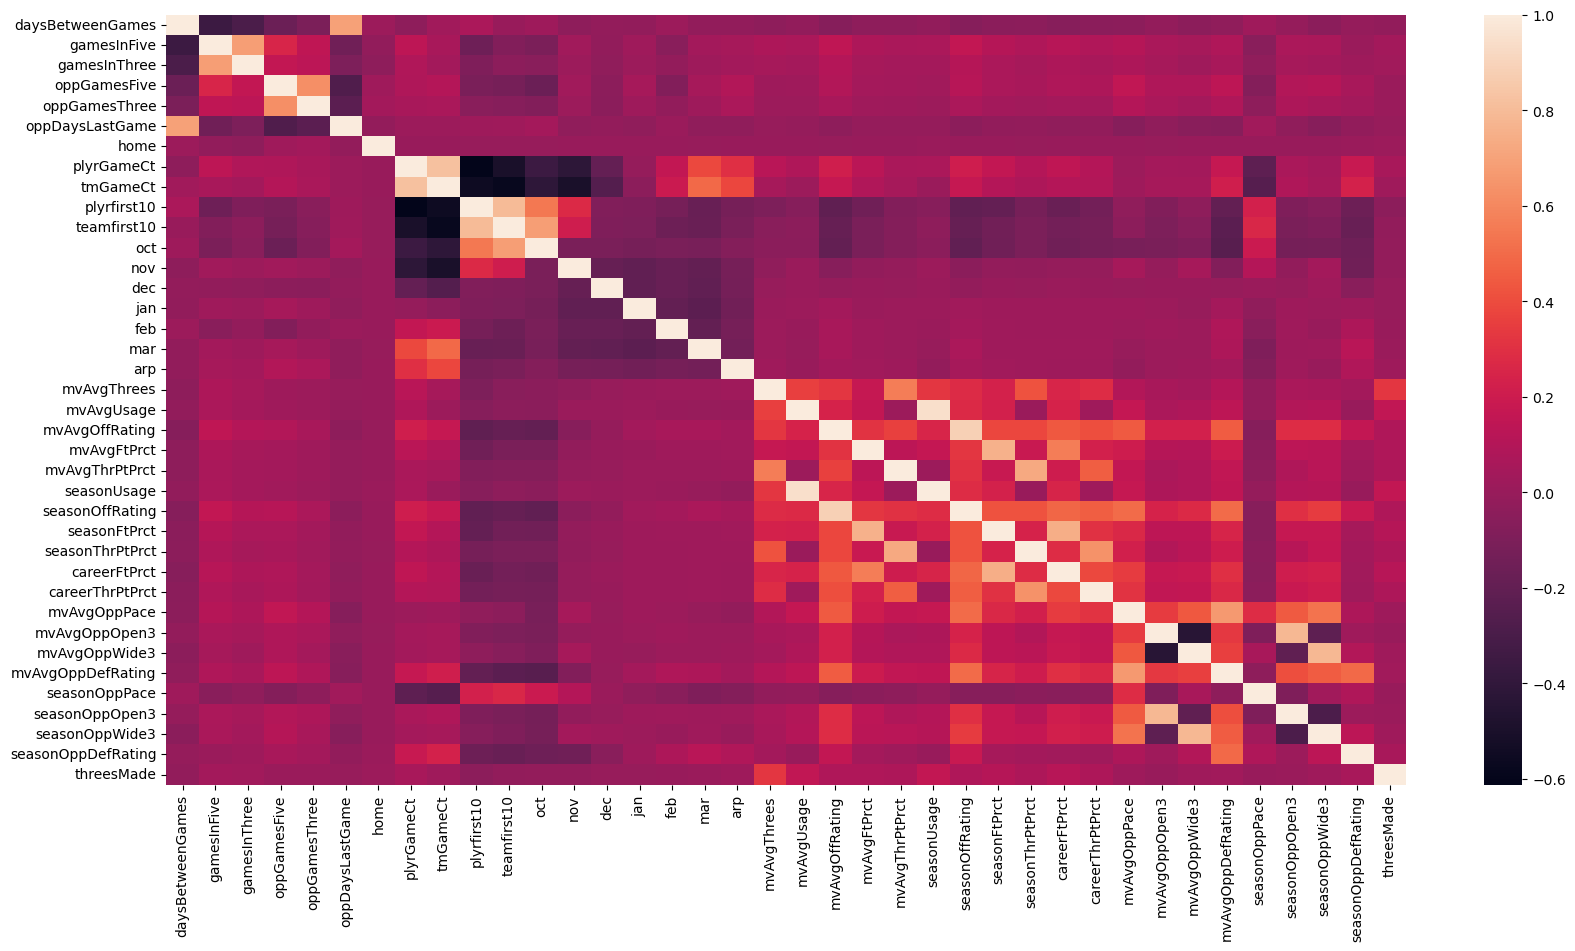

In [691]:
plt.figure(figsize=(20,10))
sns.heatmap(X.filter([col for col in X.columns if col not in ['game_date','player_id']]).join(y).corr())
plt.show()

In [692]:
X.seasonOppOpen3.value_counts()

seasonOppOpen3
0.000    274
0.333    194
0.400    163
0.429    145
0.375    126
        ... 
0.374      1
0.312      1
0.360      1
0.324      1
0.357      1
Name: count, Length: 13873, dtype: int64

In [693]:
corr = X.filter([col for col in X.columns if col not in ['game_date','player_id']]).join(y).corr()

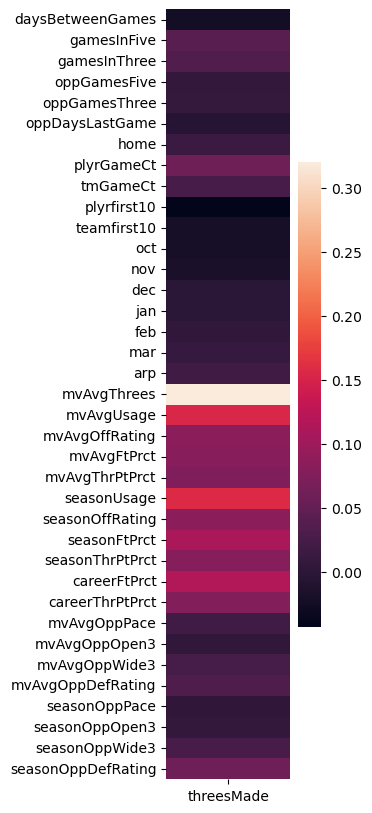

In [694]:
plt.figure(figsize=(2,10))
sns.heatmap(X.filter([col for col in X.columns if col not in ['game_date','player_id']]).join(y).corr()[['threesMade']].drop('threesMade'))
plt.show()

In [ ]:
### run linear on abv, crn and togher

In [699]:
from sklearn.preprocessing import Normalizer,StandardScaler
X.drop(['game_date','player_id'],axis=1,inplace=True)

In [700]:
#baseline with just the values getting normalized 
norm = Normalizer()
stnd = StandardScaler()

for col in X.columns:
    if col !='home':
        vals = X[col].values.reshape(-1,1)
        X[col] = stnd.fit_transform(vals)

In [701]:
X

,daysBetweenGames,gamesInFive,gamesInThree,oppGamesFive,oppGamesThree,oppDaysLastGame,home,plyrGameCt,tmGameCt,plyrfirst10,...,careerFtPrct,careerThrPtPrct,mvAvgOppPace,mvAvgOppOpen3,mvAvgOppWide3,mvAvgOppDefRating,seasonOppPace,seasonOppOpen3,seasonOppWide3,seasonOppDefRating
0,0.930,-2.197,-1.544,-3.063,-1.963,1.335,0,-1.522,-1.719,2.108,...,-6.938,-6.187,-14.823,-6.940,-7.348,-12.290,-0.422,-8.706,-9.211,-4.393
1,-0.164,-0.690,0.647,-1.217,0.509,-0.079,1,-1.470,-1.675,2.108,...,-4.748,-1.109,0.334,-1.228,2.415,-0.117,0.716,-1.505,2.980,-0.564
2,0.246,-2.197,-1.544,0.629,0.509,-0.079,1,-1.419,-1.588,2.108,...,-4.748,-1.956,-0.288,-3.160,2.592,-1.173,-0.940,-3.941,3.201,-1.710
3,-0.164,-0.690,0.647,0.629,0.509,-0.079,1,-1.368,-1.545,2.108,...,-4.018,-1.351,-0.159,0.085,-0.264,-0.722,-0.905,0.150,-0.365,-1.618
4,-0.164,0.818,0.647,-1.217,0.509,-0.079,1,-1.317,-1.501,2.108,...,-4.018,-1.273,0.588,-1.083,0.741,-0.866,1.509,-1.322,0.890,-1.291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75688,-0.301,0.818,0.647,0.629,0.509,-0.256,0,1.806,1.590,-0.474,...,-0.625,-0.107,0.212,-0.154,0.802,-0.322,1.250,-0.082,0.152,1.897
75689,-0.027,0.818,-1.544,0.629,-1.963,0.097,1,1.857,1.634,-0.474,...,-0.613,-0.106,-0.562,-0.307,-0.197,0.975,-1.018,0.137,-0.042,0.394
75690,-0.027,-0.690,-1.544,0.629,0.509,-0.079,1,1.908,1.721,-0.474,...,-0.624,-0.114,-0.052,0.408,0.152,-0.391,-0.020,-0.494,0.542,0.972
75691,-0.027,-0.690,-1.544,0.629,0.509,-0.079,0,1.959,1.764,-0.474,...,-0.629,-0.121,-0.413,-1.258,1.553,-0.274,-0.579,-1.488,1.674,0.742


In [702]:
ycat = [x if x < 7 else 7 for x in y]

In [703]:
model = sm.MNLogit(endog = y,exog = X)
results = model.fit()

         Current function value: 2.161192
         Iterations: 35


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [705]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             threesMade   No. Observations:                75693
Model:                        MNLogit   Df Residuals:                    75175
Method:                           MLE   Df Model:                          504
Date:                Sun, 29 Sep 2024   Pseudo R-squ.:                 -0.2184
Time:                        14:55:36   Log-Likelihood:            -1.6359e+05
converged:                      False   LL-Null:                   -1.3427e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
      threesMade=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
daysBetweenGames      -0.0281      0.018     -1.544      0.123      -0.064       0.008
gamesInFive            0.0428      0.019      2.290      0.022       0.006       0.079
gamesInThree           0.0164      0.018      0.923      0.356      -0.018       0.051
oppGamesFive          -0.0427      0.018     -2.388      0.017      -0.078      -0.008
oppGamesThree         -0.0048      0.017     -0.283      0.777      -0.038       0.028
oppDaysLastGame        0.0407      0.018      2.241      0.025       0.005       0.076
home                   0.4716      0.017     28.037      0.000       0.439       0.505
plyrGameCt             0.0091      0.025      0.368      0.713      -0.040       0.058
tmGameCt              -0.0203      0.039     -0.514      0.607      -0.097       0.057
plyrfirst10           -0.0027      0.023     -0.115      0.909      -0.048       0.043
teamfirst10           -0.0427      0.026     -1.671      0.095      -0.093       0.007
oct                    0.0843      0.034      2.465      0.014       0.017       0.151
nov                    0.0547      0.045      1.216      0.224      -0.034       0.143
dec                    0.0072      0.042      0.170      0.865      -0.075       0.090
jan                    0.0343      0.041      0.836      0.403      -0.046       0.115
feb                    0.0416      0.036      1.160      0.246      -0.029       0.112
mar                    0.0279      0.037      0.762      0.446      -0.044       0.100
arp                    0.0168      0.028      0.608      0.543      -0.037       0.071
mvAvgThrees            0.4333      0.021     20.312      0.000       0.392       0.475
mvAvgUsage            -0.0861      0.041     -2.114      0.034      -0.166      -0.006
mvAvgOffRating        -0.0379      0.028     -1.341      0.180      -0.093       0.017
mvAvgFtPrct            0.0105      0.019      0.552      0.581      -0.027       0.048
mvAvgThrPtPrct        -0.1105      0.020     -5.497      0.000      -0.150      -0.071
seasonUsage            0.0995      0.041      2.432      0.015       0.019       0.180
seasonOffRating        0.0421      0.030      1.426      0.154      -0.016       0.100
seasonFtPrct           0.0142      0.023      0.628      0.530      -0.030       0.059
seasonThrPtPrct        0.0589      0.020      2.915      0.004       0.019       0.098
careerFtPrct          -0.0030      0.018     -0.167      0.868      -0.038       0.032
careerThrPtPrct        0.0002      0.016      0.012      0.990      -0.031       0.032
mvAvgOppPace          -0.0067      0.029     -0.230      0.818      -0.064       0.050
mvAvgOppOpen3         -0.0243      0.031     -0.797      0.426      -0.084       0.036
mvAvgOppWide3         -0.0321      0.031     -1.045      0.296      -0.092       0.028
mvAvgOppDefRating     -0.0573      0.025     -2.300      0.021      -0.106      -0.008
seasonOppPace          0.0203      0.017      1.206      0.228      -0.013       0.053
seasonOppOpen3        

In [706]:
rs = results.summary()
rhtml = rs.tables[1].as_html()
df = pd.read_html(rhtml,header=0,index_col=0)[0]

/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_47769/3800910050.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(rhtml,header=0,index_col=0)[0]


In [ ]:
keeps =['home','usuagePercentage','pace','lc_fga','rc_fga','abv_fga','ra_fgallowed','paint_fgallowed','mid_fgallowed',
        'lc_fgallowed','rc_fgallowed','abv_fgallowed','open_fg3a','wide_fg3a','open_fg2a','wide_fg2a','daysBetweenGames','games_in_five',
        'games_in_three','mvAvgThres','mvMinThrees'

In [ ]:
df

In [ ]:
df.index[:45]

In [ ]:
df.loc['fta'].reset_index()

In [ ]:
p23['totalThrees'] = p23['lc_fga']+p23['rc_fga'] + p23['abv_fga']

In [ ]:
temp = threes.to_frame().join(p23.pct3TeamShots)
temp.columns = ['threesMade','pct3TeamShots']

In [ ]:
med = p23.groupby('name')[['lc_fga','rc_fga','abv_fga','totalThrees']].transform('median')['totalThrees']

In [ ]:
p23.loc[[x for x in np.where((med>=2) & (med<5),med.index,1) if x!=1]].groupby(['player_id','name'])[['totalThrees']].describe()

In [ ]:
model = ols('threesMade ~ c_fgaabv_fga'pct3TeamShots',data=temp)
results = model.fit()

In [ ]:
results.summary()

In [ ]:
d[(d.c_fga ** (1+d.pct3TeamShots)>1) & (d.abv_fga ** (1+d.pct3TeamShots)>6)]

In [ ]:
d[(d.c_fga>=1.5) & (d.abv_fga>4)]

In [ ]:
sns.scatterplot(d)
plt.show()

In [ ]:
p23.groupby('game_number')[['abv_fga','lc_fga','rc_fga','ts']]

In [ ]:
df23[df23.db23==-1]

In [ ]:
f23 = final.loc[dinds.get('i2023'),:]

In [ ]:
f23['dbgrp'] = kmd['Run_3']['labels']

In [ ]:
f23.dbgrp.value_counts()

In [ ]:
f23[f23.dbgrp.isin([2])].name.unique()

In [ ]:
from statsmodels.api.regress import OLS


In [ ]:
non3 = [col for col in normData.columns if (re.search('abv_fg',col)==None) & (re.search('c_fg',col)==None)]

In [ ]:
X = normData.filter(non3)

In [ ]:
y = data.rc_fgm + data.lc_fgm + data.abv_fgm

In [ ]:
model = OLS(y.loc[dinds.get('i2023')],X.loc[dinds.get('i2023')])
results = model.fit()

In [ ]:
data[(data.season=='2023-24') & (data.allstars!=0)]

In [ ]:
data17['grp15'] =  sil_score['iter_15']['labels']

In [ ]:
pSeason = plog.groupby(ind).median().reset_index()

In [ ]:
pSeason['grp3'] = sil_score['iter_3']['labels']

In [ ]:
pSeason.grp3.value_counts()

In [ ]:
chcols = ['pts','rc_fga','lc_fga','abv_fga','usagePercentage']
pSeason[pSeason.grp15.isin([1,2])].groupby('grp15')[chcols].describe()

In [ ]:
from nba_api.stats.endpoints import PlayerProfileV2
def update_undrafted_year(pids):
    for pid in tqdm(pids):
        try:
            dy = PlayerProfileV2(pid).get_data_frames()[0].SEASON_ID.min()[:4]
            nba.conn.execute(''' UPDATE players
            SET draft_year = '{}'
            where player_id  = '{}'

            '''.format(dy,pid))
            nba.conn.commit()
        except:
            print('No Data for: {}'.format(demo[demo.player_id == pid].name))

In [ ]:
def update_demo_data(plog):
    plog['season_age'] = [(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(bday)).days/ 365.25 for season,bday in zip(plog.season.values,plog.birthday)]
    plog['exp'] = plog.season.str[:4].astype(int) - plog.draft_year.astype(int)

In [ ]:
pd.read_sql('select * from pgames',nba.conn)

In [ ]:
def award_counts(demo,cols=None):
    '''
    Inputs: DF at season level, will be using season and the columns to count awards, will default to all awards
    Output: new dataframe with count columns replacings the columns for each instance
    '''
    awards = ['allstars', 'allnba_first','allnba_second', 'allnba_third', 'alld_first', 'alld_second', 'mip',
       'dpoy', 'mvp', 'finals_mvp']
    demo = demo.fillna('N/A')
    if cols == None:
        cols = awards
    lasts = ['allstars', ['allnba_first','allnba_second', 'allnba_third'],['alld_first', 'alld_second'],'mvp','dpoy']
    #This is checking to find the last time they were all-star, all-nba, all-d, mvp or dpoy, goes first to use years
    for lst in lasts:
        if isinstance(lst,str):
            demo['last_'+lst] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in zip(demo.season,demo[lst])]
        else:
            name = lst[0][:lst[0].find('_')]
            grp = zip(demo.season,[','.join(x) for x in demo.filter(lst).values])
            demo['last_'+name] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in grp]
    #This goes through every award and will update the column with a count instead of the string of instances
    for col in cols:
        demo[col] = [len([a for a in awrd.split(',') if a < season]) for season,awrd in zip(demo.season,demo[col])]
    
    return demo

In [ ]:

award_counts(t)
            

In [ ]:
t['exp'] = [int(seas[:4]) - draft for seas,draft  in zip(t.season,t.draft_year) ]
t['age'] = [t.birthday - draft for seas,draft  in zip(t.season,t.birthday) ]

In [ ]:
(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(birthday)[0]).days / 365.25

In [ ]:
[(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(bday)).days/ 365.25 for season,bday in zip(t.season.values,t.birthday)]